In [4]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

IMPORT ET STRUCTURE DES DONNEES

In [5]:
#import donn√©es
df=pd.read_csv("C:/Users/marvi/Desktop/4_Python_ML/Projet/df_logement.csv", sep = ';')

#pr√©visualtion des donn√©es
df.head()


conso_5_usages_ef  conso_5_usages_ef_energie_n1  code_departement_ban  \
0             9791.0                        9791.0                  69.0   
1             8579.9                        8579.9                  69.0   
2             9791.0                        9791.0                  69.0   
3             8579.9                        8579.9                  69.0   
4            14970.6                       14075.2                  69.0   

            adresse_brut  code_region_ban  cout_total_5_usages  \
0     1PLACE DE L'EGLISE             84.0               1635.0   
1     1PLACE DE L'EGLISE             84.0               1445.0   
2     1PLACE DE L'EGLISE             84.0               1635.0   
3     1PLACE DE L'EGLISE             84.0               1445.0   
4  All√©e des colombieres             84.0               2273.2   

   hauteur_sous_plafond nom_commune_ban  coordonnee_cartographique_x_ban  \
0                   2.3      Aigueperse                        810462.33   
1                   2.3      Aigueperse                        810462.33   
2                   2.3      Aigueperse                        810462.33   
3                   2.3      Aigueperse                        810462.33   
4                   2.5       Propi√®res                        810871.04   

  qualite_isolation_murs  ... etiquette_dpe     _score code_postal_source  \
0                  bonne  ...             F  44.682632              69790   
1                  bonne  ...             E  44.682632              69790   
2                  bonne  ...             F  44.682632              69790   
3                  bonne  ...             E  44.682632              69790   
4                  bonne  ...             E  44.682632              69790   

   annee_recherche      date_extraction        nom_rue_ban nombre_appartement  \
0             2021  2025-10-26 09:27:34  place de l'√©glise                NaN   
1             2021  2025-10-26 09:27:34  place de l'√©glise                NaN   
2             2021  2025-10-26 09:27:34  place de l'√©glise                NaN   
3             2021  2025-10-26 09:27:34  place de l'√©glise                NaN   
4             2021  2025-10-26 09:27:34                NaN                1.0   

   logement   latitude longitude  
0    ancien  46.277281  4.434599  
1    ancien  46.277281  4.434599  
2    ancien  46.277281  4.434599  
3    ancien  46.277281  4.434599  
4    ancien  46.188833  4.437585  

[5 rows x 29 columns]

In [ ]:
#type de donn√©es
df.info()

#structure des donn√©es
df.describe()


Le min et le max de la variable 'hauteur_sous_plafond' repr√©sente des valeurs aberrantes. Elles sont √† √©liminer. La fonction suivante permet d'√©liminer les valeurs aberrantes en se basant sur un crit√®re faisant intervenir l'√©cart interquartile.

In [ ]:
def remove_outliers_iqr(df, column_name, factor=1.5):
    """
    Supprime les valeurs aberrantes (outliers) d'une colonne sp√©cifique 
    dans un DataFrame en utilisant la m√©thode de l'√âcart Interquartile (EIQ).

    Args:
        df (pd.DataFrame): Le DataFrame d'entr√©e.
        column_name (str): Le nom de la colonne o√π chercher les outliers.
        factor (float): Le multiplicateur EIQ (par d√©faut est 1.5).

    Returns:
        pd.DataFrame: Un nouveau DataFrame avec les outliers supprim√©s 
                      dans la colonne sp√©cifi√©e.
    """
    
    # 1. Calcul des Quartiles
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    
    # 2. Calcul de l'√âcart Interquartile (EIQ)
    IQR = Q3 - Q1
    
    # 3. D√©finition des Limites
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # 4. Filtration des donn√©es (on garde uniquement les valeurs dans les bornes)
    # L'op√©rateur '&' sert de 'ET logique' pour les bool√©ens de Pandas
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    # 5. Affichage du nombre de lignes supprim√©es
    num_outliers = len(df) - len(df_filtered)
    print(f"‚úÖ Colonne '{column_name}' : {num_outliers} lignes consid√©r√©es comme outliers ont √©t√© supprim√©es (soit {num_outliers/len(df)*100:.2f}%).")
    
    return df_filtered

In [ ]:
df_sans_outlier = remove_outliers_iqr(df, 'hauteur_sous_plafond', factor=10)
df_sans_outlier.describe()

Etant donn√© que Q1=Q3 (la plupart des valeurs sont ramass√©es autour de 2.5m), l'√©cart interquartile est nul est les valeurs conserv√©es sont seulement celles √©gales √† 2.5m . La fonction suivante semble plus appropri√©e.

In [ ]:

def remove_outliers_zscore(df, column_name, threshold=3.0):
    """
    Supprime les valeurs aberrantes (outliers) d'une colonne sp√©cifique 
    dans un DataFrame en utilisant la m√©thode du Z-score.

    Args:
        df (pd.DataFrame): Le DataFrame d'entr√©e.
        column_name (str): Le nom de la colonne o√π chercher les outliers.
        threshold (float): Le seuil de Z-score. Les valeurs avec |Z| > seuil 
                          sont consid√©r√©es comme des outliers (par d√©faut est 3.0).

    Returns:
        pd.DataFrame: Un nouveau DataFrame avec les outliers supprim√©s 
                      dans la colonne sp√©cifi√©e.
    """
    
    # 1. Calcul de la Moyenne (mu) et de l'√âcart-type (sigma)
    mu = df[column_name].mean()
    sigma = df[column_name].std()
    
    # 2. Calcul des Z-scores
    # Le Z-score est calcul√© pour chaque point : Z = (X - mu) / sigma
    z_scores = (df[column_name] - mu) / sigma
    
    # 3. Filtration des donn√©es
    # On garde les lignes o√π la valeur absolue du Z-score est inf√©rieure ou √©gale au seuil.
    df_filtered = df[np.abs(z_scores) <= threshold]
    
    # 4. Affichage du nombre de lignes supprim√©es
    num_outliers = len(df) - len(df_filtered)
    print(f"‚úÖ Colonne '{column_name}' : {num_outliers} lignes consid√©r√©es comme outliers ont √©t√© supprim√©es (soit {num_outliers/len(df)*100:.2f}%).")
    
    return df_filtered

Notre √©tude portant sur une zone se limitant √† un d√©partement, nous √©cartons les variables g√©ographiques .

In [6]:

variables_geographiques = list(['code_departement_ban', 'adresse_brut', 'code_region_ban', 'nom_commune_ban','nom_rue_ban', 'coordonnee_cartographique_x_ban', 'adresse_ban', 'coordonnee_cartographique_y_ban', 'code_postal_ban', 'code_postal_source','nom_rue_ban', 'latitude',
       'longitude'])
df = df.drop(variables_geographiques, axis = 1)
              

In [7]:
df = df.drop('date_reception_dpe', axis=1)    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152272 entries, 0 to 1152271
Data columns (total 16 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   conso_5_usages_ef                  1152272 non-null  float64
 1   conso_5_usages_ef_energie_n1       1152272 non-null  float64
 2   cout_total_5_usages                1152272 non-null  float64
 3   hauteur_sous_plafond               1152272 non-null  float64
 4   qualite_isolation_murs             1152272 non-null  object 
 5   type_batiment                      1152272 non-null  object 
 6   type_energie_principale_chauffage  1152272 non-null  object 
 7   cout_total_5_usages_energie_n1     1152272 non-null  float64
 8   type_energie_n1                    1152272 non-null  object 
 9   surface_habitable_logement         1152272 non-null  float64
 10  etiquette_dpe                      1152272 non-null  object 
 11  _score                  

In [8]:
df = df.drop('date_extraction', axis=1)    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152272 entries, 0 to 1152271
Data columns (total 15 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   conso_5_usages_ef                  1152272 non-null  float64
 1   conso_5_usages_ef_energie_n1       1152272 non-null  float64
 2   cout_total_5_usages                1152272 non-null  float64
 3   hauteur_sous_plafond               1152272 non-null  float64
 4   qualite_isolation_murs             1152272 non-null  object 
 5   type_batiment                      1152272 non-null  object 
 6   type_energie_principale_chauffage  1152272 non-null  object 
 7   cout_total_5_usages_energie_n1     1152272 non-null  float64
 8   type_energie_n1                    1152272 non-null  object 
 9   surface_habitable_logement         1152272 non-null  float64
 10  etiquette_dpe                      1152272 non-null  object 
 11  _score                  

In [ ]:
df_sans_outlier = remove_outliers_zscore(df, 'hauteur_sous_plafond')
df_sans_outlier.describe()

In [ ]:
df_sans_outlier = remove_outliers_zscore(df, 'hauteur_sous_plafond', threshold=2)
df_sans_outlier.describe()

Il reste des valeurs √©cart√©es de la moynne mais qui ne sont plus aberrantes. (√† faire pour chaque valeur)


In [ ]:
#valeurs manquantes
df.isna().sum()

Les valeurs manquantes se trouvent principalement dans les champs d'adresse et ne concernent pas les variables qui seront utilit√©es pour la r√©gression lin√©aire. Il n'y a donc pas besoin de proc√©der √† une imputation pour ces valeurs.

In [ ]:
#doublons

def has_duplicates(data):
    
    if len(data) != len(set(data)):
        print(f'{data} contains duplicates.')
    else:
        print(f'{data} does not contain duplicates.')
        
for variable in df[df.columns]:
    has_duplicates(variable)

In [ ]:
ancien_format = df_sans_outlier.shape
df_sans_outlier.drop_duplicates()
nouveau_format = df_sans_outlier.shape
print(ancien_format,nouveau_format)

Le dataframe ne contenait pas de lignes en doublons.

MISE A L'ECHELLE DES DONNEES

Les variables √©tant utilis√©es pour effectuer une r√©gression lin√©aire, les distances sont pr√©pond√©rantes dans la pr√©diction et des √©carts trop importants perturberont le mod√®le. Nous avons donc choisi d'effectuer une standardisation des variables quantitatives plut√¥t qu'une normalisation, lorsque cela est n√©cessaires (pr√©sence de valeurs aberrantes).
La fonction ci-dessous est celle utilis√©e .

In [ ]:
def standardiser_variable(df: pd.DataFrame, column_name: str):
    """
    Standardise une colonne num√©rique d'un DataFrame en utilisant 
    la m√©thode du Z-score (centrage-r√©duction).
    
    Le Z-score de chaque valeur (X) est calcul√© comme : Z = (X - moyenne) / √©cart-type.

    Args:
        df (pd.DataFrame): Le DataFrame d'entr√©e.
        column_name (str): Le nom de la colonne num√©rique √† standardiser.

    Returns:
        pd.Series: Une nouvelle s√©rie Pandas contenant les Z-scores.
                   La s√©rie standardis√©e aura une moyenne de 0 et un √©cart-type de 1.
    """
    
    # 1. Calcul de la Moyenne (mu)
    mu = df[column_name].mean()
    
    # 2. Calcul de l'√âcart-type (sigma)
    sigma = df[column_name].std()
    
    # 3. V√©rification de l'√âcart-type pour √©viter la division par z√©ro
    if sigma == 0:
        print(f"‚ö†Ô∏è Attention : L'√©cart-type de la colonne '{column_name}' est z√©ro. La standardisation n'est pas possible.")
        # Retourne une s√©rie de z√©ros si toutes les valeurs sont identiques
        return pd.Series(0.0, index=df.index)
        
    # 4. Calcul du Z-score pour chaque valeur (Standardisation)
    z_scores = (df[column_name] - mu) / sigma
    
    print(f"‚úÖ Colonne '{column_name}' standardis√©e. Les Z-scores ont √©t√© calcul√©s.")
    
    return z_scores

In [ ]:

def standardiser_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applique la standardisation (Z-score) uniquement aux colonnes de type float 
    du DataFrame et ajoute les nouvelles colonnes au DataFrame original.
    """
    df_resultat = df.copy()
    
    # 1. Identifier UNIQUEMENT les colonnes de type float
    colonnes_float = df.select_dtypes(include=['float']).columns
    
    if len(colonnes_float) == 0:
        print("üõë Aucune colonne de type 'float' trouv√©e pour la standardisation.")
        return df_resultat
    
    print(f"üöÄ D√©but de la standardisation pour {len(colonnes_float)} colonnes de type float...")
    
    # 2. It√©rer sur chaque colonne float
    for col in colonnes_float:
        # Cr√©er le nom de la nouvelle colonne standardis√©e
        new_col_name = f"{col}_Zscore"
        
        # 3. Appliquer la standardisation
        df_resultat[new_col_name] = standardiser_variable(df_resultat, col)
        
        print(f"   -> Colonne '{col}' standardis√©e dans '{new_col_name}'.")

    print("\n‚úÖ Standardisation compl√©t√©e pour les variables float.")
    return df_resultat

In [ ]:
df_standard = standardiser_dataframe(df_sans_outlier)

REENCODAGE DES DONNEES QUALITATIVES

In [9]:
from sklearn.preprocessing import OneHotEncoder



#r√©glage encodeur
encoder = OneHotEncoder(
    sparse_output=False, 
    handle_unknown='ignore',
    drop='first' ) #drop = first permet d'√©viter la redondance 



# Liste pour stocker les DataFrames encod√©s
df_encoded_parts = []

# Liste des colonnes originales √† conserver
cols_to_keep = []

# Identification des Colonnes Qualitatives 
qualitative_cols = df.select_dtypes(include=['object']).columns.tolist()

# Si le DataFrame est tr√®s grand, une copie avant la boucle peut √™tre utile
df_processed = df.copy()

# --- 4. Boucle d'Encodage et Concat√©nation ---
for col in qualitative_cols:
    print(f"Encodage de la colonne : {col}")

    # Application de fit_transform sur la colonne actuelle
    col_reencode = encoder.fit_transform(df_processed[[col]])

    # Noms des nouvelles colonnes
    col_names = encoder.get_feature_names_out([col])

    # Cr√©ation du DataFrame des variables factices (dummies)
    df_dummies = pd.DataFrame(col_reencode, columns=col_names, index=df_processed.index)

    # Ajout du DataFrame des variables factices √† la liste
    df_encoded_parts.append(df_dummies)

    # Suppression de la colonne originale du DataFrame de travail
    df_processed = df_processed.drop(col, axis=1)


# Concat√©nation Globale

# Ajout des colonnes quantitatives non trait√©es
df_encoded_parts.insert(0, df_processed)

# Concat√©nation de toutes les parties (quantitatives originales + qualitatives encod√©es)
df_encode = pd.concat(df_encoded_parts, axis=1)



Encodage de la colonne : qualite_isolation_murs
Encodage de la colonne : type_batiment
Encodage de la colonne : type_energie_principale_chauffage
Encodage de la colonne : type_energie_n1
Encodage de la colonne : etiquette_dpe
Encodage de la colonne : logement


REGRESSION SUR LA VARIABLE 'cout_total_5_usages'

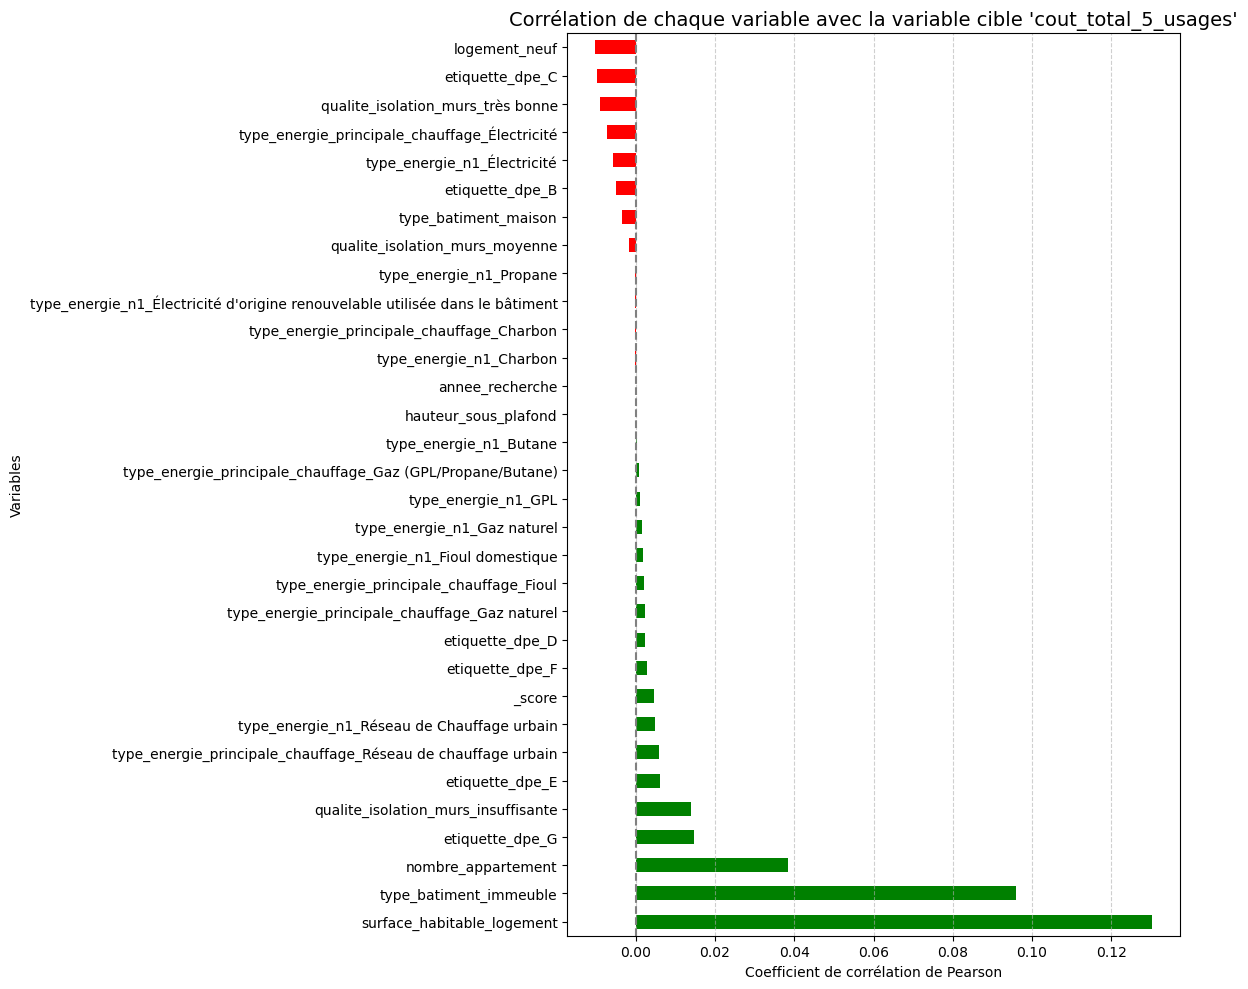

In [12]:
#Corr√©lations avec les diff√©rentes variables


colonnes_corr = [
       'cout_total_5_usages', 'hauteur_sous_plafond',
       'surface_habitable_logement',
       '_score', 'annee_recherche', 'nombre_appartement',
       'qualite_isolation_murs_insuffisante', 'qualite_isolation_murs_moyenne',
       'qualite_isolation_murs_tr√®s bonne', 'type_batiment_immeuble',
       'type_batiment_maison', 'type_energie_principale_chauffage_Charbon',
       'type_energie_principale_chauffage_Fioul',
       'type_energie_principale_chauffage_Gaz (GPL/Propane/Butane)',
       'type_energie_principale_chauffage_Gaz naturel',
       'type_energie_principale_chauffage_R√©seau de chauffage urbain',
       'type_energie_principale_chauffage_√âlectricit√©',
       'type_energie_n1_Butane', 'type_energie_n1_Charbon',
       'type_energie_n1_Fioul domestique', 'type_energie_n1_GPL',
       'type_energie_n1_Gaz naturel', 'type_energie_n1_Propane',
       'type_energie_n1_R√©seau de Chauffage urbain',
       'type_energie_n1_√âlectricit√©',
       'type_energie_n1_√âlectricit√© d\'origine renouvelable utilis√©e dans le b√¢timent',
       'etiquette_dpe_B', 'etiquette_dpe_C', 'etiquette_dpe_D',
       'etiquette_dpe_E', 'etiquette_dpe_F', 'etiquette_dpe_G',
       'logement_neuf'
]

# Matrice de corr√©lation
mat_corr = df_encode[colonnes_corr].corr('pearson')

# Isolement de la colonne des corr√©lations  
corr_avec_score = mat_corr['cout_total_5_usages'].sort_values(ascending=False)

# Supprimer 'cout_total_5_usages' 
corr_avec_score = corr_avec_score.drop('cout_total_5_usages')

# Graphique √† barres horizontal 
plt.figure(figsize=(12, 10)) 
corr_avec_score.plot(kind='barh', color=(corr_avec_score > 0).map({True: 'green', False: 'red'})) 
# La couleur est ajust√©e pour visualiser facilement les corr√©lations positives et n√©gatives

plt.title("Corr√©lation de chaque variable avec la variable cible 'cout_total_5_usages'", fontsize=14)
plt.xlabel("Coefficient de corr√©lation de Pearson")
plt.ylabel("Variables")
plt.axvline(x=0, color='grey', linestyle='--') # Ligne de r√©f√©rence √† 0
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout() # Assure que les √©tiquettes ne sont pas coup√©es
plt.show()

In [46]:
def imputer_par_moyenne(df) :
  
    # Cr√©er une copie du DataFrame pour √©viter de modifier l'original (bonne pratique)
    df_impute = df.copy()
    
    # Identifier les colonnes num√©riques
    # On it√®re uniquement sur les colonnes dont le type est float
    colonnes_numeriques = df_impute.select_dtypes(include='float64').columns
    
    print(f"Colonnes num√©riques √† imputer : {list(colonnes_numeriques)}")

    # Parcourir les colonnes num√©riques
    for colonne in colonnes_numeriques:
        # Calculer la moyenne de la colonne
        moyenne_colonne = df_impute[colonne].mean()
        
        # Remplacer les NaN par cette moyenne
        df_impute[colonne].fillna(moyenne_colonne, inplace=True)
        
        print(f"  -> Colonne '{colonne}' : {df_impute[colonne].isnull().sum()} NaN restants (Moyenne utilis√©e: {moyenne_colonne:.2f})")
        
    print("\n‚úÖ Imputation termin√©e.")
    return df_impute

In [45]:
#choix cible et variables
cible = ['cout_total_5_usages']
variables_regression = [
        'hauteur_sous_plafond',
       'surface_habitable_logement',
       '_score', 'nombre_appartement',
       'qualite_isolation_murs_insuffisante', 'qualite_isolation_murs_moyenne',
       'qualite_isolation_murs_tr√®s bonne', 'type_batiment_immeuble',
       'type_batiment_maison',
       'type_energie_principale_chauffage_Fioul',
       'type_energie_principale_chauffage_Gaz (GPL/Propane/Butane)',
       'type_energie_principale_chauffage_Gaz naturel',
       'type_energie_principale_chauffage_R√©seau de chauffage urbain',
       'type_energie_principale_chauffage_√âlectricit√©',
      
       'type_energie_n1_Fioul domestique', 'type_energie_n1_GPL',
       'type_energie_n1_Gaz naturel',
       'type_energie_n1_R√©seau de Chauffage urbain',
       'type_energie_n1_√âlectricit√©',
       'etiquette_dpe_B', 'etiquette_dpe_C', 'etiquette_dpe_D',
       'etiquette_dpe_E', 'etiquette_dpe_F', 'etiquette_dpe_G',
       'logement_neuf'
]

X = imputer_par_moyenne(X).values 
X = df_encode[variables_regression]
y = df_encode[cible].values

AttributeError: 'numpy.ndarray' object has no attribute 'select_dtypes'

In [ ]:



X = df_encode[variables_regression]
y = df_encode[cible].values

Colonnes num√©riques √† imputer : ['hauteur_sous_plafond', 'surface_habitable_logement', '_score', 'nombre_appartement', 'qualite_isolation_murs_insuffisante', 'qualite_isolation_murs_moyenne', 'qualite_isolation_murs_tr√®s bonne', 'type_batiment_immeuble', 'type_batiment_maison', 'type_energie_principale_chauffage_Fioul', 'type_energie_principale_chauffage_Gaz (GPL/Propane/Butane)', 'type_energie_principale_chauffage_Gaz naturel', 'type_energie_principale_chauffage_R√©seau de chauffage urbain', 'type_energie_principale_chauffage_√âlectricit√©', 'type_energie_n1_Fioul domestique', 'type_energie_n1_GPL', 'type_energie_n1_Gaz naturel', 'type_energie_n1_R√©seau de Chauffage urbain', 'type_energie_n1_√âlectricit√©', 'etiquette_dpe_B', 'etiquette_dpe_C', 'etiquette_dpe_D', 'etiquette_dpe_E', 'etiquette_dpe_F', 'etiquette_dpe_G', 'logement_neuf']
  -> Colonne 'hauteur_sous_plafond' : 0 NaN restants (Moyenne utilis√©e: 2.61)
  -> Colonne 'surface_habitable_logement' : 0 NaN restants (Moyenne 

C:\Users\marvi\AppData\Local\Temp\ipykernel_6536\1395253277.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_impute[colonne].fillna(moyenne_colonne, inplace=True)


  -> Colonne 'etiquette_dpe_G' : 0 NaN restants (Moyenne utilis√©e: 0.03)
  -> Colonne 'logement_neuf' : 0 NaN restants (Moyenne utilis√©e: 0.14)

‚úÖ Imputation termin√©e.


In [24]:
from sklearn.model_selection import train_test_split

#pr√©paration des donn√©es
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

print("The dimension of X_train is {}".format(X_train.shape))
print("The dimension of X_test is {}".format(X_test.shape))
#Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The dimension of X_train is (806590, 26)
The dimension of X_test is (345682, 26)


In [25]:
#choix mod√®le
lr = LinearRegression()
#entra√Ænement
lr.fit(X_train,y_train)
#prediction
y_pred = lr.predict(X_test)
#print(y_test)
print(lr.coef_)


[[-4.41981693e+00  4.24042085e+03  1.49280478e+02  1.16224796e+02
   6.20353199e+01  1.02789255e+01 -1.22744775e+02  9.31885270e+02
   7.76413932e-01  1.28287458e+01  1.69254359e+01  7.73355494e+01
   1.08328318e+02  3.37084412e+01 -5.63498590e+00  1.64457204e+01
   9.10389443e+01 -1.62899180e+01  8.58418632e-01  4.64762893e+01
   2.30877476e+02  4.83001985e+02  5.43037085e+02  3.80513612e+02
   7.98411878e+02  4.32471349e+00]]


ESTIMATION DU MODELE

In [26]:
train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)

print("The train score for lr model is {}".format(train_score_lr))
print("The test score for lr model is {}".format(test_score_lr))

The train score for lr model is 0.017830965357636286
The test score for lr model is 0.0182875280462913


In [ ]:
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedKFold

# D√©couper y en classes (bins) pour la stratification
y_bins = np.digitize(y, np.quantile(y, np.arange(0, 1, 0.01))) # 100 bins
skf_reg = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lr, X, y_bins, cv=skf_reg)
R2_moyen = np.mean(scores)


print(f"Les scores pour chaque fold sot : {scores} ")
print(f"R¬≤ moyen avec RepeatedKFold : {R2_moyen:.4f} sur {len(scores)} scores.")

Le score pour chaque fold est[0.52101815 0.5193097  0.51983886 0.52272551 0.52122779] 
R¬≤ moyen avec RepeatedKFold : 0.5208 sur 5 scores.


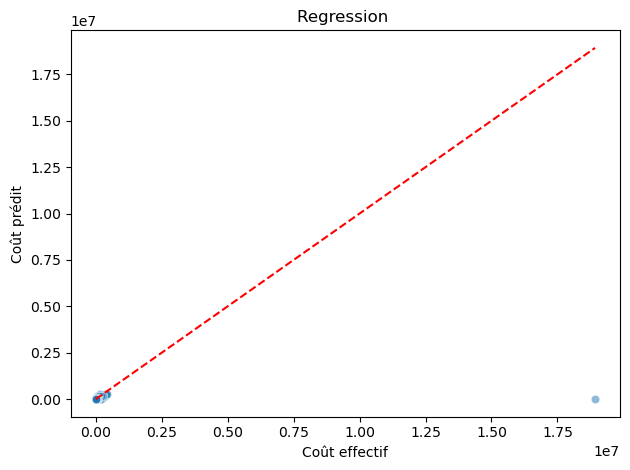

In [ ]:
# Compute residuals.

residuals = y_test - y_pred

# Plot: Regression Fit (Actual vs Predicted).

sb.scatterplot(x=y_test[:,0], y=y_pred[:,0], alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect fit line
plt.title("Regression ")
plt.xlabel("Co√ªt effectif")
plt.ylabel("Co√ªt pr√©dit")


# Show plots.
plt.tight_layout()
plt.show()